### Plot functions

In [132]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

# from sklearn import set_config
# set_config(display="diagram")

from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict

from sklearn.model_selection import train_test_split

def create_regressors():
    
    # create processors
    
    cat_selector = make_column_selector(dtype_include=object)
    num_selector = make_column_selector(dtype_include=np.number)

    cat_tree_processor = OrdinalEncoder(
        handle_unknown="use_encoded_value", unknown_value=-1)
    num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

    tree_preprocessor = make_column_transformer(
        (num_tree_processor, num_selector), (cat_tree_processor, cat_selector))

    cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
    num_linear_processor = make_pipeline(
        SimpleImputer(strategy="mean", add_indicator=True) # no need for scaler since already scaled
    )

    linear_preprocessor = make_column_transformer(
        (num_linear_processor, num_selector), (cat_linear_processor, cat_selector))

    # create pipelines
    
    lasso_pipeline = make_pipeline(linear_preprocessor, LassoCV())
    rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(random_state=42))
    gbdt_pipeline = make_pipeline(tree_preprocessor, HistGradientBoostingRegressor(random_state=0))

    # create regressors
    
    estimators = [
        ("Random Forest", rf_pipeline),
        ("Lasso", lasso_pipeline),
        ("Gradient Boosting", gbdt_pipeline),]

    stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
    
    return estimators, stacking_regressor
    
    
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "--r", linewidth=2
    )
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    extra = plt.Rectangle(
        (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0
    )
    ax.legend([extra], [scores], loc="upper left")
    title = title + "\n Evaluation in {:.2f} seconds".format(elapsed_time)
    ax.set_title(title)


def plot_multiple_regressions(X, y):
    
    estimators, stacking_regressor = create_regressors()

    fig, axs = plt.subplots(1, 4, figsize=(14, 4))
    axs = np.ravel(axs)

    for ax, (name, est) in zip(
        axs, estimators + [("Stacking Regressor", stacking_regressor)]
    ):
        start_time = time.time()
        score = cross_validate(
            est, X, y, scoring=["r2", "neg_mean_absolute_error"], n_jobs=-1, verbose=0
        )
        elapsed_time = time.time() - start_time

        y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)
       
        
        plot_regression_results(
            ax,
            y,
            y_pred,
            name,
            (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
                np.mean(score["test_r2"]),
                np.std(score["test_r2"]),
                -np.mean(score["test_neg_mean_absolute_error"]),
                np.std(score["test_neg_mean_absolute_error"]),
            ),
            elapsed_time,
        )

#     plt.suptitle("Single predictors versus stacked predictors")
    plt.tight_layout()
#     plt.subplots_adjust(top=0.9)
    plt.show()
    
    
def evaluate_linear_regressors(df_scaler, df, target_column_name):
    
    print(df_scaler)
    
    # Fit the scaler
    df_scaler.fit(df)

    # Scale the data
    scaled_df = df_scaler.transform(df)
    scaled_df = pd.DataFrame(scaled_df, columns=df.columns, index=df.index)

    y = scaled_df[target_column_name]
    X = scaled_df.drop(target_column_name, axis=1)
        
    plot_multiple_regressions(X, y)
    

### Pre-processing dataset

In [138]:
# import dependencies

import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

import plotly.express as px
import hvplot.pandas
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TweedieRegressor

### Download data from AWS RDS to DataFrame

In [142]:
# Database engine to connect with AWS RDS

dialect = 'postgresql'
username = 'postgres'
password = 'bootcamp2021'
host = 'bootcamp-final-cln.ch1wrcuq3max.us-east-2.rds.amazonaws.com'
database = 'crime'
engine = create_engine(f'{dialect}://{username}:{password}@{host}/{database}')

In [143]:
# upload additional tables

# property_type_df_file = os.path.join('data_prep', 'property_type_df.csv')
# pd.read_csv(property_type_df_file).to_sql(name='property_type_crime', con=engine, if_exists='replace')

# violent_type_df_file = os.path.join('data_prep', 'violent_type_df.csv')
# pd.read_csv(violent_type_df_file).to_sql(name='violent_type_crime', con=engine, if_exists='replace')

In [144]:
# list all the tables on the AWS RDS

inspector = inspect(engine)
inspector.get_table_names()

OperationalError: (psycopg2.OperationalError) could not translate host name "bootcamp-final-cln.ch1wrcuq3max.us-east-2.rds.amazonaws.com" to address: Unknown host

(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [ ]:
with engine.connect() as conn:
    violent_crime_df = pd.read_sql("SELECT * FROM violent_type_crime", conn)
    property_crime_df = pd.read_sql("SELECT * FROM property_type_crime", conn)

property_crime_df.drop(['index'], axis=1, inplace=True)
property_crime_df.set_index('FIPS', inplace=True)

violent_crime_df.drop('index', axis=1, inplace=True)
violent_crime_df.set_index('FIPS', inplace=True)

print(property_crime_df.shape)
print(violent_crime_df.shape)

In [156]:
# download dataset from local .csv files
property_crime_file = os.path.join('data_prep', 'property_type_df.csv')
violent_crime_file = os.path.join('data_prep', 'violent_type_df.csv')

property_crime_df = pd.read_csv(property_crime_file)
property_crime_df.drop('FIPS', axis=1, inplace=True)

violent_crime_df = pd.read_csv(violent_crime_file)
violent_crime_df.drop('FIPS', axis=1, inplace=True)

In [157]:
violent_crime_df

,crimes,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17
0,55.0,69,31,38,11.483395,33.588459,28.356571,26.571573,4.0,58233.0,55200,35.853419,12.1,15.9,14.4
1,163.0,296,111,185,9.193843,27.659616,31.284081,31.862459,4.2,59871.0,208107,50.541504,10.1,13.5,13.3
2,3.0,10,9,1,20.942602,44.878773,23.800098,10.378526,4.5,47918.0,22527,13.973114,20.3,25.9,25.2
3,18.0,56,51,5,15.567326,32.790615,33.160995,18.481064,5.1,47747.0,115098,73.348688,17.2,24.6,22.8
4,58.0,53,34,19,14.843810,37.834648,29.174259,18.147284,5.4,46683.0,54495,35.496950,14.6,19.4,18.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,10.0,71,35,36,4.009988,34.635723,38.572269,22.782021,4.6,78055.0,9951,0.786272,7.2,8.2,7.4
1996,23.0,95,39,56,7.213361,33.041271,37.246979,22.498390,4.7,80639.0,44117,1.633615,8.3,10.1,8.2
1997,2.0,47,34,13,7.258562,41.522678,35.189754,16.029003,4.7,70756.0,20609,3.822405,8.5,9.6,7.8
1998,4.0,9,8,1,10.241615,29.751171,36.620987,23.386225,4.1,55122.0,8129,1.402002,11.1,13.9,12.3


In [158]:
property_crime_df

,crimes,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17
0,384.0,69,31,38,11.483395,33.588459,28.356571,26.571573,4.0,58233.0,55200,35.853419,12.1,15.9,14.4
1,737.0,296,111,185,9.193843,27.659616,31.284081,31.862459,4.2,59871.0,208107,50.541504,10.1,13.5,13.3
2,69.0,10,9,1,20.942602,44.878773,23.800098,10.378526,4.5,47918.0,22527,13.973114,20.3,25.9,25.2
3,211.0,56,51,5,15.567326,32.790615,33.160995,18.481064,5.1,47747.0,115098,73.348688,17.2,24.6,22.8
4,267.0,53,34,19,14.843810,37.834648,29.174259,18.147284,5.4,46683.0,54495,35.496950,14.6,19.4,18.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2066,81.0,71,35,36,4.009988,34.635723,38.572269,22.782021,4.6,78055.0,9951,0.786272,7.2,8.2,7.4
2067,99.0,95,39,56,7.213361,33.041271,37.246979,22.498390,4.7,80639.0,44117,1.633615,8.3,10.1,8.2
2068,78.0,47,34,13,7.258562,41.522678,35.189754,16.029003,4.7,70756.0,20609,3.822405,8.5,9.6,7.8
2069,11.0,9,8,1,10.241615,29.751171,36.620987,23.386225,4.1,55122.0,8129,1.402002,11.1,13.9,12.3


### Pre-processing violent crimes

#### examine the dataset

In [160]:
# change index to default

original_df = violent_crime_df.copy()
original_df

,crimes,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17
0,55.0,69,31,38,11.483395,33.588459,28.356571,26.571573,4.0,58233.0,55200,35.853419,12.1,15.9,14.4
1,163.0,296,111,185,9.193843,27.659616,31.284081,31.862459,4.2,59871.0,208107,50.541504,10.1,13.5,13.3
2,3.0,10,9,1,20.942602,44.878773,23.800098,10.378526,4.5,47918.0,22527,13.973114,20.3,25.9,25.2
3,18.0,56,51,5,15.567326,32.790615,33.160995,18.481064,5.1,47747.0,115098,73.348688,17.2,24.6,22.8
4,58.0,53,34,19,14.843810,37.834648,29.174259,18.147284,5.4,46683.0,54495,35.496950,14.6,19.4,18.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,10.0,71,35,36,4.009988,34.635723,38.572269,22.782021,4.6,78055.0,9951,0.786272,7.2,8.2,7.4
1996,23.0,95,39,56,7.213361,33.041271,37.246979,22.498390,4.7,80639.0,44117,1.633615,8.3,10.1,8.2
1997,2.0,47,34,13,7.258562,41.522678,35.189754,16.029003,4.7,70756.0,20609,3.822405,8.5,9.6,7.8
1998,4.0,9,8,1,10.241615,29.751171,36.620987,23.386225,4.1,55122.0,8129,1.402002,11.1,13.9,12.3


In [161]:
# normalize columns against population

norm_df = original_df.copy()

columns_to_normalize = [
    'crimes',
    'total_law_emp',
    'officers',
    'civilians']

for col in columns_to_normalize:
    norm_df[col] = norm_df[col] / norm_df['population']

norm_df.head()

,crimes,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17
0,0.000996,0.001250,0.000562,0.000688,11.483395,33.588459,28.356571,26.571573,4.0,58233.0,55200,35.853419,12.1,15.9,14.4
1,0.000783,0.001422,0.000533,0.000889,9.193843,27.659616,31.284081,31.862459,4.2,59871.0,208107,50.541504,10.1,13.5,13.3
2,0.000133,0.000444,0.000400,0.000044,20.942602,44.878773,23.800098,10.378526,4.5,47918.0,22527,13.973114,20.3,25.9,25.2
3,0.000156,0.000487,0.000443,0.000043,15.567326,32.790615,33.160995,18.481064,5.1,47747.0,115098,73.348688,17.2,24.6,22.8
4,0.001064,0.000973,0.000624,0.000349,14.843810,37.834648,29.174259,18.147284,5.4,46683.0,54495,35.496950,14.6,19.4,18.6


### Linear Regression for the entire dataset

StandardScaler()


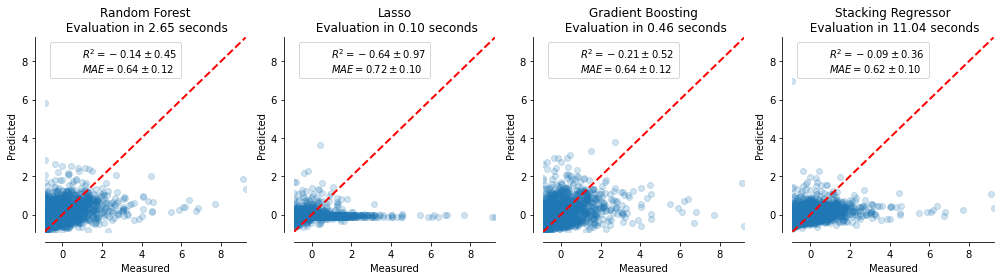

StandardScaler(with_mean=False)


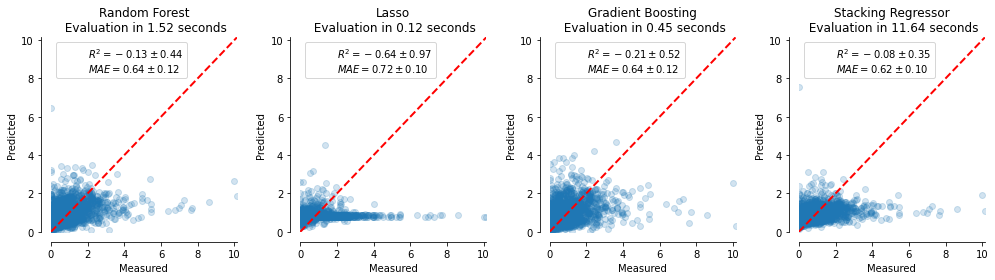

QuantileTransformer(output_distribution='normal', random_state=0)


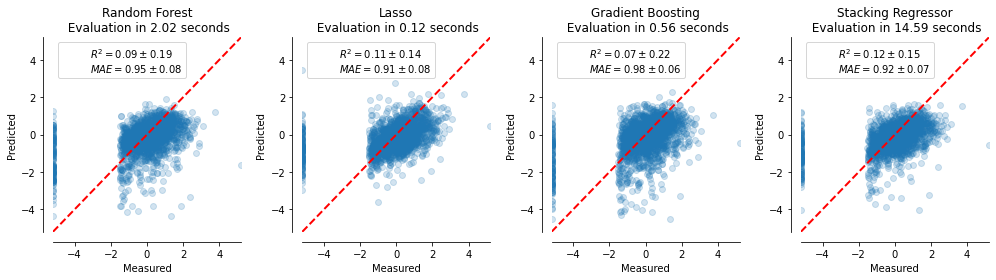

PowerTransformer()


C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


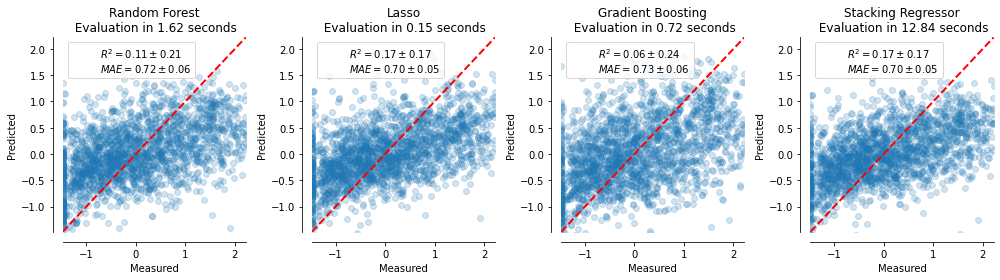

In [162]:
# Create scaler instance

scalers = [ StandardScaler(),
            StandardScaler(with_mean=False), # keep positive
            QuantileTransformer(random_state=0, output_distribution='normal'),
            PowerTransformer(method="yeo-johnson")]

for sclr in scalers:
    evaluate_linear_regressors(sclr, norm_df, 'crimes')

### Remove datapoints with 0 crimes and 0 civilian law employees

In [165]:
# remove rows of 0 crimes and 0 civilians

clean_df = norm_df.copy()
clean_df = clean_df[(clean_df['crimes']>0) & (clean_df['civilians']>0)]
clean_df.reset_index(drop=True, inplace=True)
clean_df

,crimes,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17
0,0.000996,0.001250,0.000562,0.000688,11.483395,33.588459,28.356571,26.571573,4.0,58233.0,55200,35.853419,12.1,15.9,14.4
1,0.000783,0.001422,0.000533,0.000889,9.193843,27.659616,31.284081,31.862459,4.2,59871.0,208107,50.541504,10.1,13.5,13.3
2,0.000133,0.000444,0.000400,0.000044,20.942602,44.878773,23.800098,10.378526,4.5,47918.0,22527,13.973114,20.3,25.9,25.2
3,0.000156,0.000487,0.000443,0.000043,15.567326,32.790615,33.160995,18.481064,5.1,47747.0,115098,73.348688,17.2,24.6,22.8
4,0.001064,0.000973,0.000624,0.000349,14.843810,37.834648,29.174259,18.147284,5.4,46683.0,54495,35.496950,14.6,19.4,18.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1804,0.000200,0.001899,0.000666,0.001233,4.672548,25.635998,38.734070,30.957382,4.0,64030.0,30012,4.592168,8.5,10.0,8.6
1805,0.001005,0.007135,0.003517,0.003618,4.009988,34.635723,38.572269,22.782021,4.6,78055.0,9951,0.786272,7.2,8.2,7.4
1806,0.000521,0.002153,0.000884,0.001269,7.213361,33.041271,37.246979,22.498390,4.7,80639.0,44117,1.633615,8.3,10.1,8.2
1807,0.000097,0.002281,0.001650,0.000631,7.258562,41.522678,35.189754,16.029003,4.7,70756.0,20609,3.822405,8.5,9.6,7.8


StandardScaler()


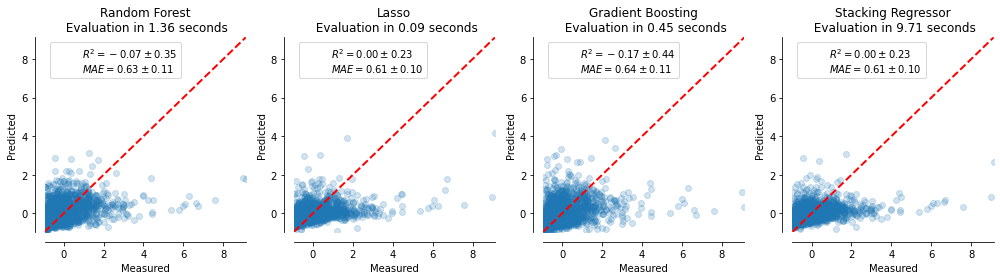

StandardScaler(with_mean=False)


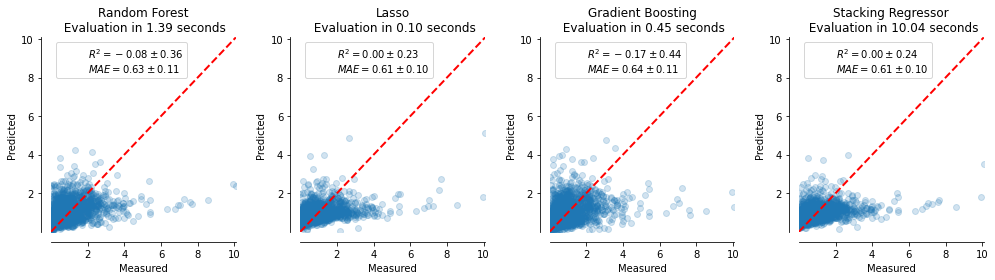

QuantileTransformer(output_distribution='normal', random_state=0)


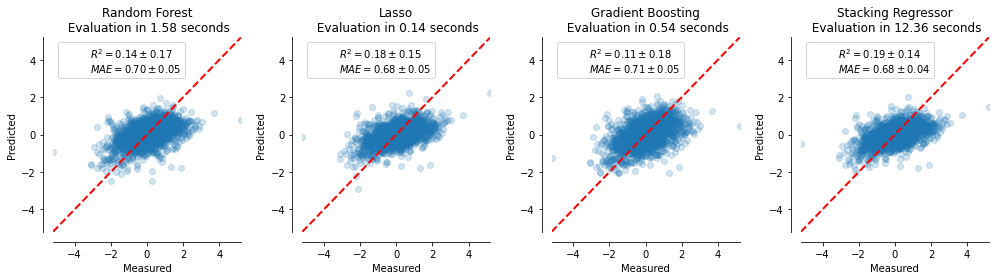

PowerTransformer()


C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


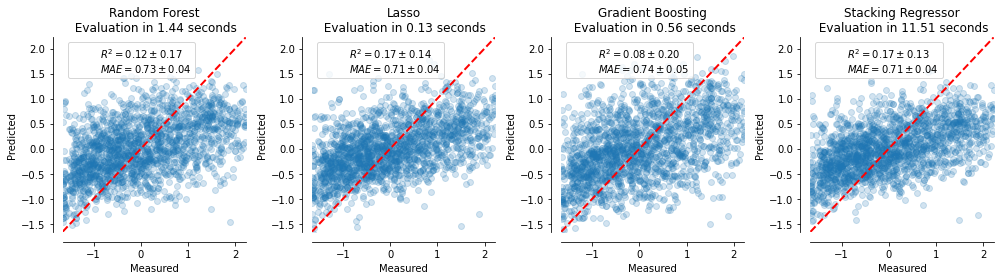

In [166]:
for sclr in scalers:
    evaluate_linear_regressors(sclr, clean_df, 'crimes')

### Create a classifier to predict 0 crime

In [170]:
min(norm_df['crimes'])

0.0

In [174]:
classifier_df = norm_df.copy()
classifier_df['class'] = classifier_df['crimes'] > 0
classifier_df

,crimes,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17,class
0,0.000996,0.001250,0.000562,0.000688,11.483395,33.588459,28.356571,26.571573,4.0,58233.0,55200,35.853419,12.1,15.9,14.4,True
1,0.000783,0.001422,0.000533,0.000889,9.193843,27.659616,31.284081,31.862459,4.2,59871.0,208107,50.541504,10.1,13.5,13.3,True
2,0.000133,0.000444,0.000400,0.000044,20.942602,44.878773,23.800098,10.378526,4.5,47918.0,22527,13.973114,20.3,25.9,25.2,True
3,0.000156,0.000487,0.000443,0.000043,15.567326,32.790615,33.160995,18.481064,5.1,47747.0,115098,73.348688,17.2,24.6,22.8,True
4,0.001064,0.000973,0.000624,0.000349,14.843810,37.834648,29.174259,18.147284,5.4,46683.0,54495,35.496950,14.6,19.4,18.6,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.001005,0.007135,0.003517,0.003618,4.009988,34.635723,38.572269,22.782021,4.6,78055.0,9951,0.786272,7.2,8.2,7.4,True
1996,0.000521,0.002153,0.000884,0.001269,7.213361,33.041271,37.246979,22.498390,4.7,80639.0,44117,1.633615,8.3,10.1,8.2,True
1997,0.000097,0.002281,0.001650,0.000631,7.258562,41.522678,35.189754,16.029003,4.7,70756.0,20609,3.822405,8.5,9.6,7.8,True
1998,0.000492,0.001107,0.000984,0.000123,10.241615,29.751171,36.620987,23.386225,4.1,55122.0,8129,1.402002,11.1,13.9,12.3,True


In [175]:
classifier_df[classifier_df['class']==False]

,crimes,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17,class
186,0.0,0.005401,0.002315,0.003086,12.628337,28.131416,39.219711,20.020535,1.7,53577.0,1296,0.310083,12.6,18.5,18.3,False
198,0.0,0.000926,0.000926,0.000000,11.500000,33.107143,31.571428,23.821428,1.5,53432.0,4318,2.423494,10.4,14.8,14.2,False
201,0.0,0.004331,0.001701,0.002630,8.117731,31.521481,37.621647,22.739141,3.6,65960.0,6465,0.774968,10.3,12.8,11.3,False
204,0.0,0.002783,0.001237,0.001546,16.939325,30.544626,30.420378,22.095673,4.1,37004.0,6468,0.788151,25.4,38.8,34.3,False
205,0.0,0.005515,0.005515,0.000000,6.185567,25.773195,32.371136,35.670105,2.1,50524.0,544,0.542016,13.7,19.3,20.3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741,0.0,0.000205,0.000171,0.000034,6.313773,26.946108,24.912575,41.827545,3.0,65879.0,58477,32.862793,8.4,9.3,8.0,False
1743,0.0,0.000307,0.000289,0.000018,6.566021,29.086006,26.114803,38.233170,2.6,61843.0,55427,22.071963,9.2,9.6,8.7,False
1758,0.0,0.002543,0.001565,0.000978,9.167992,37.519875,29.676735,23.635401,4.3,53319.0,5113,6.016919,11.2,19.1,18.1,False
1959,0.0,0.002402,0.001965,0.000437,8.095781,42.569366,31.394907,17.939947,5.9,40300.0,4579,4.943763,25.3,44.0,44.7,False


In [176]:
classifier_df.drop('crimes', axis=1, inplace=True)
classifier_df

,total_law_emp,officers,civilians,percent_edu_less_than_high_school,percent_edu_high_school,percent_edu_some_college,percent_edu_bachelor_or_higher,unemployment_rate,median_HH_Income,population,pop_dens_ppl_per_sqkm,percent_poverty_all_age,percent_poverty_age_0-17,percent_poverty_age_5-17,class
0,0.001250,0.000562,0.000688,11.483395,33.588459,28.356571,26.571573,4.0,58233.0,55200,35.853419,12.1,15.9,14.4,True
1,0.001422,0.000533,0.000889,9.193843,27.659616,31.284081,31.862459,4.2,59871.0,208107,50.541504,10.1,13.5,13.3,True
2,0.000444,0.000400,0.000044,20.942602,44.878773,23.800098,10.378526,4.5,47918.0,22527,13.973114,20.3,25.9,25.2,True
3,0.000487,0.000443,0.000043,15.567326,32.790615,33.160995,18.481064,5.1,47747.0,115098,73.348688,17.2,24.6,22.8,True
4,0.000973,0.000624,0.000349,14.843810,37.834648,29.174259,18.147284,5.4,46683.0,54495,35.496950,14.6,19.4,18.6,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.007135,0.003517,0.003618,4.009988,34.635723,38.572269,22.782021,4.6,78055.0,9951,0.786272,7.2,8.2,7.4,True
1996,0.002153,0.000884,0.001269,7.213361,33.041271,37.246979,22.498390,4.7,80639.0,44117,1.633615,8.3,10.1,8.2,True
1997,0.002281,0.001650,0.000631,7.258562,41.522678,35.189754,16.029003,4.7,70756.0,20609,3.822405,8.5,9.6,7.8,True
1998,0.001107,0.000984,0.000123,10.241615,29.751171,36.620987,23.386225,4.1,55122.0,8129,1.402002,11.1,13.9,12.3,True


In [184]:
from sklearn.linear_model import LogisticRegression

    
target_column_name = 'class'
y = classifier_df[target_column_name]
X = classifier_df.drop(target_column_name, axis=1)

# Fit the scaler
df_scaler.fit(X)

# Scale the data
scaled_X = df_scaler.transform(X)
scaled_X = pd.DataFrame(scaled_X, columns=X.columns, index=X.index)

# Use the train_test_split function to create training and testing subsets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
X_train.shape

(1500, 14)

In [185]:
# Instantiate a linear SVM model
from sklearn.svm import SVC
model = SVC(kernel='linear')

In [186]:
# Fit the data
model.fit(X_train, y_train)

SVC(kernel='linear')

In [193]:
# Make predictions using the test data
y_pred = model.predict(X_test)
results = pd.DataFrame({
    "Prediction": y_pred, 
    "Actual": y_test
}).reset_index(drop=True)
results.sample(50)

,Prediction,Actual
307,True,False
340,True,True
379,True,True
177,True,True
394,True,True
79,True,True
216,True,True
298,True,True
339,True,True
335,True,True


In [188]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.936

In [190]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[  0,  32],
       [  0, 468]], dtype=int64)

In [191]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00        32
        True       0.94      1.00      0.97       468

    accuracy                           0.94       500
   macro avg       0.47      0.50      0.48       500
weighted avg       0.88      0.94      0.91       500



C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [202]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)

In [203]:
# Train the data
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=1)

In [204]:
# Predict outcomes for test data set
y_pred = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results.head(20)

,Prediction,Actual
0,True,True
1,True,True
2,True,True
3,True,True
4,True,False
5,True,True
6,True,True
7,True,True
8,True,True
9,True,False


In [206]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.928
[[  0  32]
 [  4 464]]
              precision    recall  f1-score   support

       False       0.00      0.00      0.00        32
        True       0.94      0.99      0.96       468

    accuracy                           0.93       500
   macro avg       0.47      0.50      0.48       500
weighted avg       0.88      0.93      0.90       500



In [208]:
# Undersample the data using `RandomUnderSampler`
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({False: 98, True: 98})

In [209]:
# Fit a Logistic regression model using random undersampled data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [210]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 21,  11],
       [120, 348]], dtype=int64)

In [211]:
# Calculate the Balanced Accuracy Score
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)

0.6999198717948718

In [212]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

      False       0.15      0.66      0.74      0.24      0.70      0.48        32
       True       0.97      0.74      0.66      0.84      0.70      0.49       468

avg / total       0.92      0.74      0.66      0.80      0.70      0.49       500



In [213]:
results = pd.DataFrame({
    "Prediction": y_pred, 
    "Actual": y_test
}).reset_index(drop=True)
results.sample(50)

,Prediction,Actual
41,True,True
362,False,True
253,True,True
459,True,True
414,False,True
447,False,True
299,False,True
377,True,True
301,True,True
29,True,True


In [214]:
# implement random oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

Counter(y_resampled)

Counter({True: 1402, False: 1402})

In [215]:
# Logistic regression using random oversampled data
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [216]:
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 22,  10],
       [130, 338]], dtype=int64)

In [218]:
print(balanced_accuracy_score(y_test, y_pred))
print(classification_report_imbalanced(y_test, y_pred))

0.7048611111111112
                   pre       rec       spe        f1       geo       iba       sup

      False       0.14      0.69      0.72      0.24      0.70      0.49        32
       True       0.97      0.72      0.69      0.83      0.70      0.50       468

avg / total       0.92      0.72      0.69      0.79      0.70      0.50       500



In [219]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy='auto').fit_resample(
    X_train, y_train
)
Counter(y_resampled)

Counter({True: 1402, False: 1402})

In [220]:
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [221]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.7457264957264957

In [223]:
print(confusion_matrix(y_test, y_pred))

print(classification_report_imbalanced(y_test, y_pred))

[[ 24   8]
 [121 347]]
                   pre       rec       spe        f1       geo       iba       sup

      False       0.17      0.75      0.74      0.27      0.75      0.56        32
       True       0.98      0.74      0.75      0.84      0.75      0.56       468

avg / total       0.93      0.74      0.75      0.81      0.75      0.56       500



KeyboardInterrupt: 

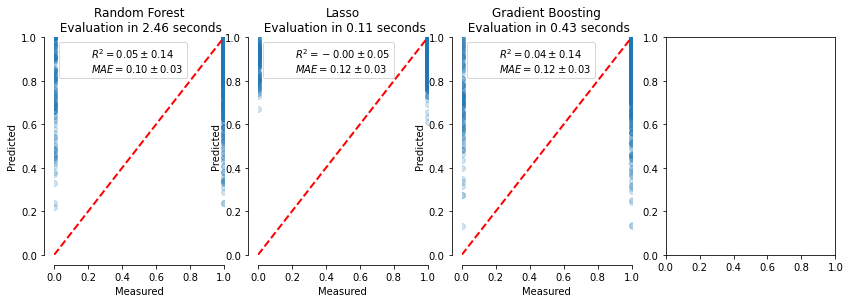

In [183]:
plot_multiple_regressions(scaled_X, y)

clf = LogisticRegression(random_state=0).fit(X, y)
clf.predict(X)

In [ ]:
plt.scatter(norm_df['crimes'], norm_df['crimes'])

In [ ]:
columns = list(norm_df.columns)
len(columns)

In [ ]:
columns

In [ ]:
display_columns = columns[1:5]
display_columns.append('crimes')
print(display_columns)

sns.pairplot(norm_df[display_columns], 
             diag_kind='kde').map_lower(sns.kdeplot, levels=4, color='.2')

In [ ]:
inertia = []
k = list(range(1, 11))

# Looking for the best K
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(norm_df)
    inertia.append(km.inertia_)
    
# Define a DataFrame to plot the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", title="Elbow Curve", xticks=k)

In [ ]:
def get_clusters(k, data):
    # Create a copy of the DataFrame
    data = data.copy()

    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Fit the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)

    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_.astype(str)

    return data

In [ ]:
n_cluster = 2

clusters_df = get_clusters(n_cluster, norm_df)
clusters_df.head()


clusters_df.groupby(by='class').count()

In [ ]:
# Plotting the clusters with three features
fig = px.scatter_3d(clusters_df, 
                    x="total_law_emp", 
#                     range_x=[min(clusters_df['total_law_emp']), max(clusters_df['total_law_emp'])/250],
                    y="median_HH_Income", 
                    z="crimes", 
                    color="class", 
                    symbol="class", 
#                     size="crime_to_pop_ratio",
                    width=800)
fig.update_layout(legend=dict(x=0,y=1))
fig.show()

In [ ]:
#!/usr/bin/env python

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

x = norm_df['civilians']

num_bins = 1000
# the histogram of the data
plt.figure(figsize=(18, 6), dpi=80)

n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5, edgecolor='black')

plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title(r'Histogram of IQ: $\mu=100$, $\sigma=15$')

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

In [ ]:
print(original_df['crimes'].value_counts())
print(original_df['civilians'].value_counts())

In [ ]:
# filter crimes=0
zero_df = original_df[(original_df['crimes']==0) | (original_df['civilians']==0)]
zero_df

In [ ]:
# remove rows of 0 crimes and 0 civilians

clean_df = original_df[(original_df['crimes']>0) & (original_df['civilians']>0)]
clean_df.reset_index(drop=True, inplace=True)
clean_df

#### normalize a few columns against population

In [ ]:
# normalize columns against population

norm_df = clean_df.copy()

columns_to_normalize = [
    'crimes',
    'total_law_emp',
    'officers',
    'civilians'    
]

for col in columns_to_normalize:
    norm_df[col] = clean_df[col] / clean_df['population']

norm_df.head()

### Check skewness

In [ ]:
norm_df.skew()

In [ ]:
skewed_columns = ['crimes',
                  'total_law_emp',
                  'officers',
                  'civilians',
                  'population',
                  'pop_dens_ppl_per_sqkm']

In [ ]:
# scaled_df = norm_df.copy()

# from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

# Create scaler instance

df_scaler = QuantileTransformer(random_state=0, output_distribution='normal')
# df_scaler = StandardScaler(with_mean=False) # keep positive
# df_scaler = StandardScaler() 
# df_scaler = PowerTransformer(method="yeo-johnson")

# Fit the scaler
df_scaler.fit(norm_df)
# y_scaler.fit(np.asarray(y).reshape(-1, 1))

# Scale the data
scaled_df = df_scaler.transform(norm_df)
scaled_df = pd.DataFrame(scaled_df, columns=norm_df.columns, index=norm_df.index)
# scaled_y = y_scaler.transform(np.asarray(y).reshape(-1, 1))
# scaled_y = pd.DataFrame(scaled_y, columns=['crimes'], index=X.index)

scaled_df.head()

scaled_df.skew()

In [ ]:
sns.pairplot(scaled_df[skewed_columns], 
             diag_kind='kde').map_lower(sns.kdeplot, levels=4, color='.2')

Select QuantileTransformer as the scaler

### Create input and target 

In [ ]:
y = scaled_df['crimes']
X = scaled_df.drop('crimes', axis=1)

In [ ]:
print(y.skew())
print(X.skew())

### Build pipeline to preprocess the data

In [ ]:
from sklearn import set_config

set_config(display="diagram")

In [ ]:
from sklearn.compose import make_column_selector

cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)
# cat_selector(X)

In [ ]:
# num_selector(X)

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)
tree_preprocessor

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = make_pipeline(
#     PowerTransformer(method="yeo-johnson"), SimpleImputer(strategy="mean", add_indicator=True)
#     QuantileTransformer(n_quantiles=1000, random_state=0, output_distribution='normal'), 
#     SimpleImputer(strategy="mean", add_indicator=True)
#     StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
#     StandardScaler(with_mean=False), SimpleImputer(strategy="mean", add_indicator=True)
    SimpleImputer(strategy="mean", add_indicator=True) # no need for scaler since already scaled
)

linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
)
linear_preprocessor

In [ ]:
from sklearn.linear_model import LassoCV

lasso_pipeline = make_pipeline(linear_preprocessor, LassoCV())
lasso_pipeline

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(random_state=42))
rf_pipeline

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

gbdt_pipeline = make_pipeline(
    tree_preprocessor, HistGradientBoostingRegressor(random_state=0)
)
gbdt_pipeline

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

estimators = [
    ("Random Forest", rf_pipeline),
    ("Lasso", lasso_pipeline),
    ("Gradient Boosting", gbdt_pipeline),
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
stacking_regressor

In [ ]:
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict


def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "--r", linewidth=2
    )
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    extra = plt.Rectangle(
        (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0
    )
    ax.legend([extra], [scores], loc="upper left")
    title = title + "\n Evaluation in {:.2f} seconds".format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimators + [("Stacking Regressor", stacking_regressor)]
):
    start_time = time.time()
    score = cross_validate(
        est, X, y, scoring=["r2", "neg_mean_absolute_error"], n_jobs=2, verbose=0
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=2, verbose=0)

    plot_regression_results(
        ax,
        y,
        y_pred,
        name,
        (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
            np.mean(score["test_r2"]),
            np.std(score["test_r2"]),
            -np.mean(score["test_neg_mean_absolute_error"]),
            np.std(score["test_neg_mean_absolute_error"]),
        ),
        elapsed_time,
    )

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### None of the above linear or tree models achieved acceptable accuracy.
### Try unsupervised machine learning to identify clusters and improve accuracy

In [ ]:
scaled_df

In [ ]:
inertia = []
k = list(range(1, 11))

# Looking for the best K
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(scaled_df)
    inertia.append(km.inertia_)
    
# Define a DataFrame to plot the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", title="Elbow Curve", xticks=k)

4 clusters

In [ ]:
n_cluster = 4

In [ ]:
def get_clusters(k, data):
    # Create a copy of the DataFrame
    data = data.copy()

    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Fit the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)

    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_.astype(str)

    return data

In [ ]:
clusters_df = get_clusters(n_cluster, scaled_df)
clusters_df.head()

In [ ]:
clusters_df.groupby(by='class').count()

In [ ]:
# Plotting the clusters with three features
fig = px.scatter_3d(clusters_df, 
                    x="total_law_emp", 
#                     range_x=[min(clusters_df['total_law_emp']), max(clusters_df['total_law_emp'])/250],
                    y="median_HH_Income", 
                    z="crimes", 
                    color="class", 
                    symbol="class", 
#                     size="crime_to_pop_ratio",
                    width=800)
fig.update_layout(legend=dict(x=0,y=1))
fig.show()

Cluster 1 appears to be an outlier

In [ ]:
n_cluster = 4

In [ ]:
for i in range(n_cluster):

    cluster_no = i

    cluster_subset_df = clusters_df[clusters_df['class']==str(cluster_no)]
    cluster_subset_df.drop('class', axis=1, inplace=True)

    if cluster_subset_df.shape[0]>2:

        y = cluster_subset_df['crimes']
        X = cluster_subset_df.drop('crimes', axis=1)

        fig, axs = plt.subplots(2, 2, figsize=(9, 7))
        axs = np.ravel(axs)

        for ax, (name, est) in zip(
            axs, estimators + [("Stacking Regressor", stacking_regressor)]
        ):
            start_time = time.time()
            score = cross_validate(
                est, X, y, scoring=["r2", "neg_mean_absolute_error"], n_jobs=2, verbose=0
            )
            elapsed_time = time.time() - start_time

            y_pred = cross_val_predict(est, X, y, n_jobs=2, verbose=0)

            plot_regression_results(
                ax,
                y,
                y_pred,
                name,
                (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
                    np.mean(score["test_r2"]),
                    np.std(score["test_r2"]),
                    -np.mean(score["test_neg_mean_absolute_error"]),
                    np.std(score["test_neg_mean_absolute_error"]),
                ),
                elapsed_time,
            )

        plt.suptitle(f"--------Cluster {i}--------")
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

### Examine the distribution of "Crimes" data

In [ ]:
sns.displot(clusters_df.reset_index(), 
            x="crimes",
#             kind='kde',
#             cut=0,
            hue='class',
#             log_scale=True,
            kde=True
            )

### Try NN model

In [ ]:
cluster_no = 1

In [ ]:
cluster_subset_df = clusters_df[clusters_df['class']==str(cluster_no)]
cluster_subset_df.drop('class', axis=1, inplace=True)


nn_y = cluster_subset_df['crimes']
nn_X = cluster_subset_df.drop('crimes', axis=1)

X_train, X_test, y_train, y_test = train_test_split(nn_X, nn_y, random_state=78)

In [ ]:
units_input = 8
units_h1 = 0
units_h2 = 0
units_h3 = 0
activation_input = 'LeakyReLU'
activation_h1 = 'LeakyReLU'
activation_h2 = 'LeakyReLU'
activation_h3 = 'LeakyReLU'
activation_output = 'linear'
epochs = 500


# Create the Keras Sequential model
nn_model = tf.keras.models.Sequential()
nn_model.add(tf.keras.layers.Dense(units=units_input, activation=activation_input, input_dim=nn_X.shape[1]))
if units_h1 > 0:
    nn_model.add(tf.keras.layers.Dense(units=units_h1, activation=activation_h1))
if units_h2 > 0:
    nn_model.add(tf.keras.layers.Dense(units=units_h2, activation=activation_h2))
if units_h3 > 0:
    nn_model.add(tf.keras.layers.Dense(units=units_h3, activation=activation_h3))
nn_model.add(tf.keras.layers.Dense(units=1, activation=activation_output))

# Check the structure of the Sequential model
print(nn_model.summary())

# Compile the Sequential model together and customize metrics
nn_model.compile(loss="mean_absolute_error", 
                 optimizer=tf.optimizers.Adam(learning_rate=0.001), 
#                  metrics=["r_square"]
                )

# Fit the model to the training data
fit_model = nn_model.fit(X_train, y_train, epochs=epochs, verbose=0)

# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# compare R^2 between train and test
y_train_pred = nn_model.predict(X_train)
y_test_pred = nn_model.predict(X_test)

r2_train = r2_score(y_train,y_train_pred)
r2_test = r2_score(y_test,y_test_pred)

print(f'training R2: {r2_score(y_train,y_train_pred)}')
print(f'testing R2: {r2_score(y_test,y_test_pred)}')

# Plot the loss
history_df.plot(y="loss")

# compare Predicted with True
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), tight_layout=True)
ax1.scatter(y_train, y_train_pred, color='r', alpha=0.2, label='train')
ax1.scatter(y_test, y_test_pred, color='b', alpha=0.5, label='test')
# ax1.scatter(result['True'],result['Predicted'])
ax1.plot([min(nn_y), max(nn_y)], [min(nn_y), max(nn_y)], '--r')
ax1.legend(loc='best')
ax1.set_xlabel('True')
ax1.set_ylabel('Predicted')
# ax2.scatter(result['True'], result['Predicted'])
# ax2.plot([0, 0.2], [0, 0.2], 'r')
# ax2.set_xlim(0, 0.25)
# ax2.set_ylim(0, 0.25)
# ax2.set_xlabel('True')
# ax2.set_title('Zoom into Diagnol')


### dimentionality reduction

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import hvplot.pandas

In [ ]:
scaled_df.head()

In [ ]:
sum_explained_variance_ratio = []

for i in range(scaled_df.shape[1]):
    # Initialize PCA model
    pca = PCA(n_components=i)

    # Get i principal components 
    df_pca = pca.fit_transform(scaled_df)

    pca_df = pd.DataFrame(
        data=df_pca, #columns=['pc1','pc2','pc3','pc4']
    )

    sum_explained_variance_ratio.append(sum(pca.explained_variance_ratio_))

In [ ]:
sum_explained_variance_ratio

In [ ]:
plt.plot(range(scaled_df.shape[1]), sum_explained_variance_ratio, marker='x')

Number of PCs is selected to be 6

In [ ]:
pca = PCA(n_components=6)

# Get i principal components 
df_pca = pca.fit_transform(scaled_df)

pca_df = pd.DataFrame(
    data=df_pca, #columns=['pc1','pc2','pc3','pc4']
)

In [ ]:
pca_df.head()

In [ ]:
# Find the best value for K
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of K values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pca_df)
    inertia.append(km.inertia_)

# Create the elbow curve
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

In [ ]:
# Initialize the K-means model
model = KMeans(n_clusters=4, random_state=0)

# Fit the model
model.fit(pca_df)

# Predict clusters
predictions = model.predict(pca_df)

# Add the predicted class columns
pca_df["class"] = model.labels_
pca_df.head()

In [ ]:
pca_df.hvplot.scatter(
    x="0",
    y="1",
    hover_cols=["class"],
    by="class",
)

In [ ]:
# Plotting the clusters with three features
fig = px.scatter_3d(pca_df, 
                    x=0, 
#                     range_x=[min(clusters_df['total_law_emp']), max(clusters_df['total_law_emp'])/250],
                    y=1, 
                    z=2, 
                    color="class", 
                    symbol="class",
                    width=800)
fig.update_layout(legend=dict(x=0,y=1))
fig.show()

In [ ]:
pca_df.groupby(by='class').count()

In [ ]:
scaled_classified_df = scaled_df.reset_index().copy()
scaled_classified_df['class'] = pca_df['class']
scaled_classified_df

In [ ]:
n_cluster = 4

for i in range(n_cluster):

    cluster_no = i

    cluster_subset_df = scaled_classified_df[scaled_classified_df['class']==cluster_no]
    cluster_subset_df.drop('class', axis=1, inplace=True)

    if cluster_subset_df.shape[0]>2:

        y = cluster_subset_df['crimes']
        X = cluster_subset_df.drop('crimes', axis=1)

        fig, axs = plt.subplots(2, 2, figsize=(9, 7))
        axs = np.ravel(axs)

        for ax, (name, est) in zip(
            axs, estimators + [("Stacking Regressor", stacking_regressor)]
        ):
            start_time = time.time()
            score = cross_validate(
                est, X, y, scoring=["r2", "neg_mean_absolute_error"], n_jobs=2, verbose=0
            )
            elapsed_time = time.time() - start_time

            y_pred = cross_val_predict(est, X, y, n_jobs=2, verbose=0)

            plot_regression_results(
                ax,
                y,
                y_pred,
                name,
                (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
                    np.mean(score["test_r2"]),
                    np.std(score["test_r2"]),
                    -np.mean(score["test_neg_mean_absolute_error"]),
                    np.std(score["test_neg_mean_absolute_error"]),
                ),
                elapsed_time,
            )

        plt.suptitle(f"--------Cluster {i}--------")
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()